# Kidney Stone Detection Model Evaluation - MobileNetV3

This notebook evaluates the performance of the trained MobileNetV3 model for kidney stone detection from CT scan images.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import custom_object_scope
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns

c:\Users\manob\Documents\Kidney_Disease_Detection\Kidney_Disease_Detection\.conda\Lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\manob\Documents\Kidney_Disease_Detection\Kidney_Disease_Detection\.conda\Lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\manob\Documents\Kidney_Disease_Detection\Kidney_Disease_Detection\.conda\Lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
%pwd

'c:\\Users\\manob\\Documents\\Kidney_Disease_Detection\\Kidney_Disease_Detection\\Pretrained Models\\MobileNetV3'

In [3]:
os.chdir("../")
os.chdir("../")

In [4]:
%pwd

'c:\\Users\\manob\\Documents\\Kidney_Disease_Detection\\Kidney_Disease_Detection'

In [5]:
# Define focal loss function to handle loading the model
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -tf.reduce_sum(alpha * tf.pow(1. - pt_1, gamma) * tf.math.log(pt_1)) - tf.reduce_sum((1-alpha) * tf.pow(pt_0, gamma) * tf.math.log(1. - pt_0))
    return focal_loss_fixed

# Create the focal loss function with specific parameters
focal_loss_fn = focal_loss(gamma=2.0, alpha=0.25)

In [6]:
# Configuration
BASE_DIR = "artifacts/data_ingestion/Combined_Training_Data"
MODEL_PATH = "Pretrained Models/MobileNetV3/mobilenetv3_kidney_stone_model_trained.h5"  # Path to the trained model
IMAGE_SIZE = (320, 320)  # Make sure this matches the model's input size
BATCH_SIZE = 32

# Create directory for evaluation results
RESULTS_DIR = "Pretrained Models/MobileNetV3/evaluation_results"
os.makedirs(RESULTS_DIR, exist_ok=True)

In [7]:
# Load the trained model with custom loss function
with custom_object_scope({'focal_loss_fixed': focal_loss_fn}):
    model = load_model(MODEL_PATH)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 320, 320, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 160, 160, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

In [8]:
# Define preprocessing function for CT images
def preprocess_ct_image(img):
    # Convert to float
    img = img.astype('float32')
    
    # Normalize to [0,1]
    img = img / 255.0
    
    # Apply contrast stretching - enhance the contrast of CT images
    p2, p98 = np.percentile(img, (2, 98))
    img = np.clip((img - p2) / (p98 - p2), 0, 1)
    
    return img

# Create a test data generator with preprocessing
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_ct_image)

# We'll use the validation split as our test set for evaluation
test_generator = test_datagen.flow_from_directory(
    BASE_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False  # Important: don't shuffle for evaluation
)

# Print class mapping
print(f"Class indices: {test_generator.class_indices}")

Found 38821 images belonging to 2 classes.
Class indices: {'Non-Stone': 0, 'Stone': 1}


In [9]:
# Evaluate the model
evaluation = model.evaluate(test_generator)
metrics_names = model.metrics_names

# Print evaluation results
print("\nModel Evaluation Results:")
for name, value in zip(metrics_names, evaluation):
    print(f"{name}: {value:.4f}")

1214/1214 [==============================] - 745s 612ms/step - loss: 1.2009 - accuracy: 0.8333 - auc: 0.9274 - precision: 0.9307 - recall: 0.6961

Model Evaluation Results:
loss: 1.2009
accuracy: 0.8333
auc: 0.9274
precision: 0.9307
recall: 0.6961


In [10]:
# Get predictions
test_generator.reset()
y_pred_prob = model.predict(test_generator)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()
y_true = test_generator.classes

# Make sure predictions and true labels have the same length
y_pred = y_pred[:len(y_true)]
y_pred_prob = y_pred_prob[:len(y_true)]

1214/1214 [==============================] - 764s 629ms/step


In [11]:
# Generate classification report
class_names = list(test_generator.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=class_names)
print("\nClassification Report:")
print(report)

# Save the report to a file
with open(f"{RESULTS_DIR}/classification_report.txt", "w") as f:
    f.write(report)


Classification Report:
              precision    recall  f1-score   support

   Non-Stone       0.78      0.95      0.86     20627
       Stone       0.93      0.70      0.80     18194

    accuracy                           0.83     38821
   macro avg       0.86      0.83      0.83     38821
weighted avg       0.85      0.83      0.83     38821



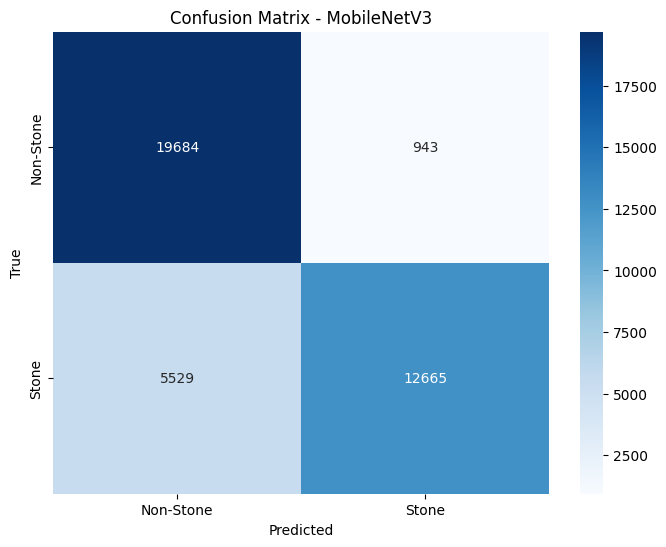

In [12]:
# Generate and plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - MobileNetV3')
plt.savefig(f"{RESULTS_DIR}/confusion_matrix.png", bbox_inches='tight')
plt.show()

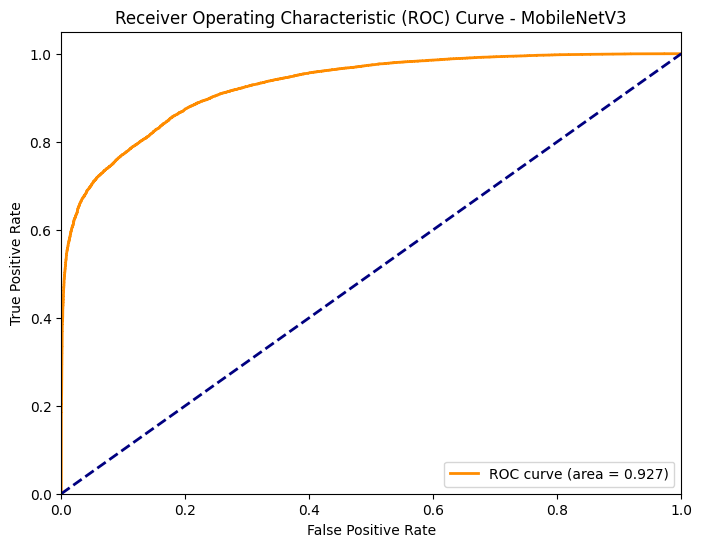

In [13]:
# Generate and plot ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - MobileNetV3')
plt.legend(loc="lower right")
plt.savefig(f"{RESULTS_DIR}/roc_curve.png", bbox_inches='tight')
plt.show()

1/1 [==============================] - 1s 1s/step


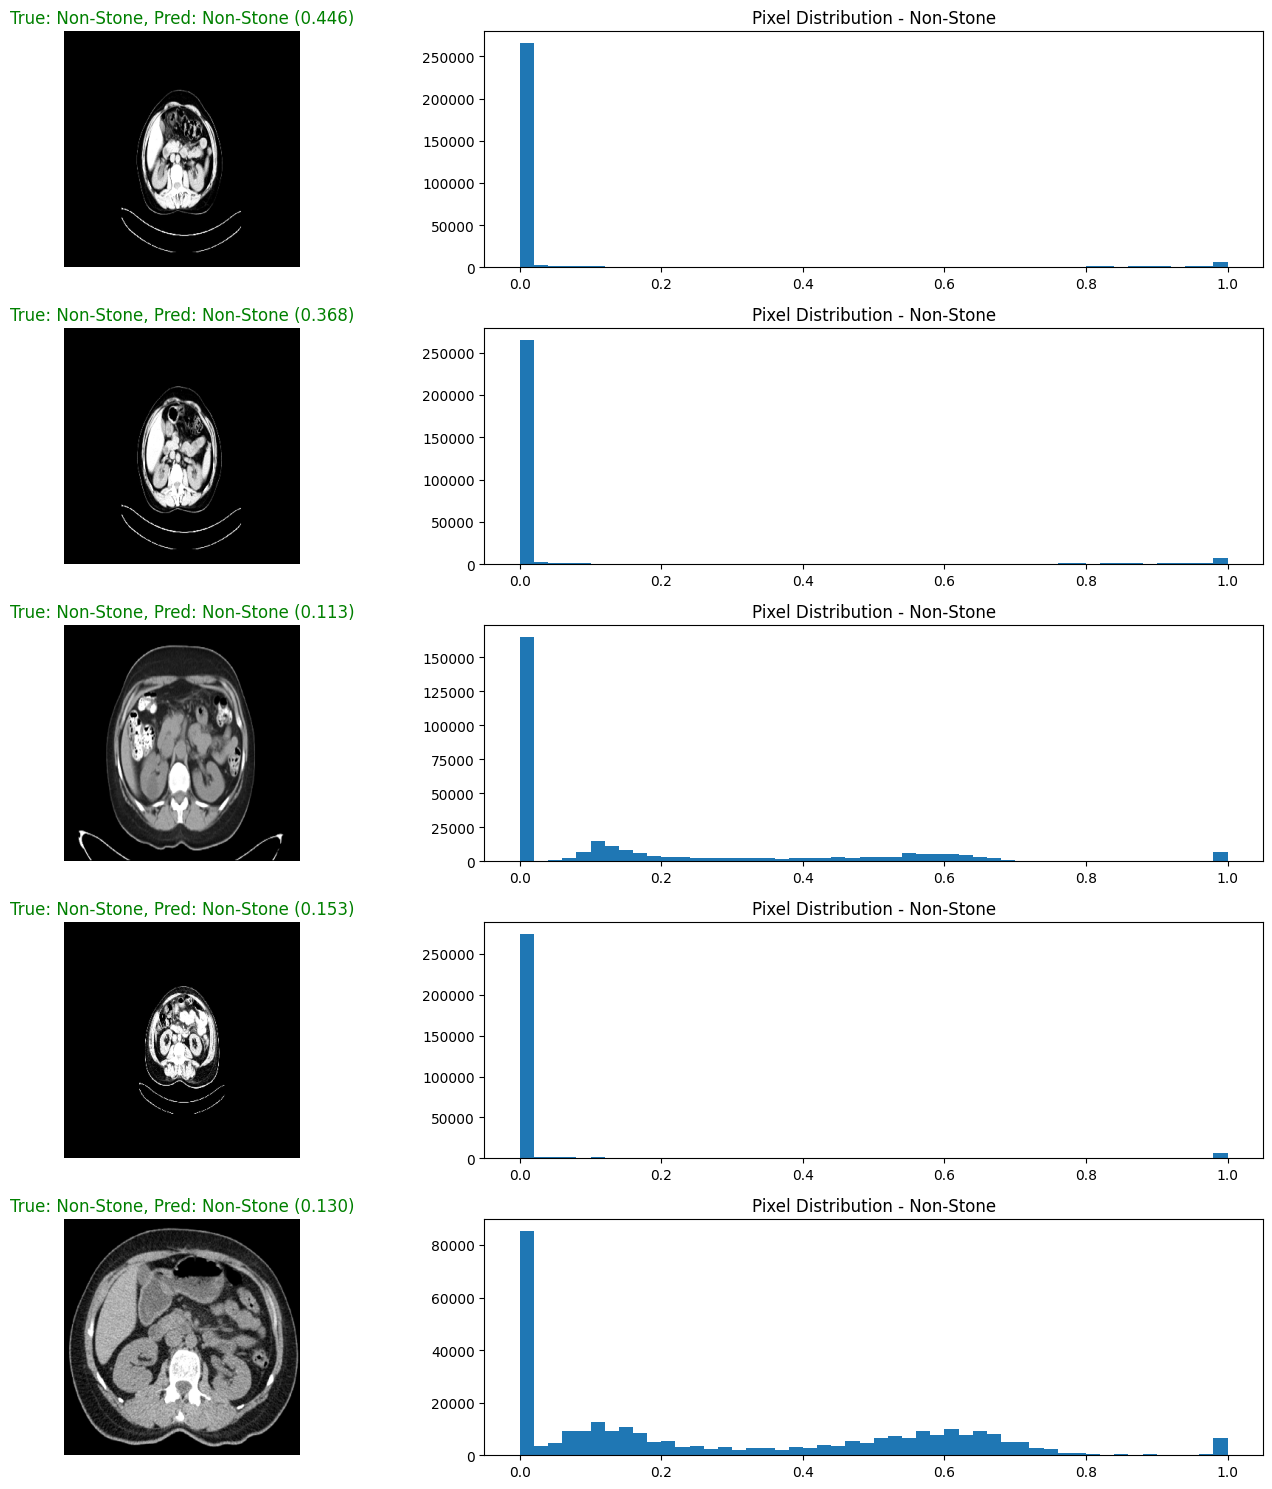

In [14]:
# Visualize some example predictions
def plot_sample_predictions(generator, model, num_samples=5):
    generator.reset()
    
    # Get a batch of images and their true labels
    batch_x, batch_y = next(generator)
    
    # Make predictions
    preds = model.predict(batch_x)
    
    # Plot the images with their predictions
    plt.figure(figsize=(15, 3*num_samples))
    for i in range(min(num_samples, len(batch_x))):
        plt.subplot(num_samples, 2, 2*i+1)
        plt.imshow(batch_x[i])
        true_label = "Stone" if batch_y[i] == 1 else "Non-Stone"
        pred_label = "Stone" if preds[i][0] > 0.5 else "Non-Stone"
        pred_prob = preds[i][0]
        title = f"True: {true_label}, Pred: {pred_label} ({pred_prob:.3f})"
        plt.title(title, color='green' if true_label == pred_label else 'red')
        plt.axis('off')
        
        # Add a histogram of pixel values to understand image characteristics
        plt.subplot(num_samples, 2, 2*i+2)
        plt.hist(batch_x[i].flatten(), bins=50)
        plt.title(f"Pixel Distribution - {true_label}")
    
    plt.tight_layout()
    plt.savefig(f"{RESULTS_DIR}/sample_predictions.png", bbox_inches='tight')
    plt.show()

# Plot some sample predictions
plot_sample_predictions(test_generator, model, num_samples=5)

In [15]:
# Calculate and print additional metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("\nAdditional Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Save metrics to a file
with open(f"{RESULTS_DIR}/metrics_summary.txt", "w") as f:
    f.write(f"Accuracy: {accuracy:.4f}\n")
    f.write(f"Precision: {precision:.4f}\n")
    f.write(f"Recall: {recall:.4f}\n")
    f.write(f"F1 Score: {f1:.4f}\n")
    f.write(f"ROC AUC: {roc_auc:.4f}\n")

print(f"\nMetrics saved to {RESULTS_DIR}/metrics_summary.txt")


Additional Metrics:
Accuracy: 0.8333
Precision: 0.9307
Recall: 0.6961
F1 Score: 0.7965
ROC AUC: 0.9274

Metrics saved to Pretrained Models/MobileNetV3/evaluation_results/metrics_summary.txt


In [16]:
# Analyze model performance by confidence level
confidence_bins = np.linspace(0, 1, 11)  # 10 bins from 0 to 1
bin_indices = np.digitize(y_pred_prob, confidence_bins) - 1  # -1 to make 0-indexed

# Calculate accuracy for each confidence bin
bin_accuracies = []
bin_counts = []

for i in range(len(confidence_bins) - 1):
    bin_mask = (bin_indices == i)
    if np.sum(bin_mask) > 0:  # Only calculate if there are samples in this bin
        bin_acc = accuracy_score(y_true[bin_mask], y_pred[bin_mask])
        bin_accuracies.append(bin_acc)
        bin_counts.append(np.sum(bin_mask))
    else:
        bin_accuracies.append(0)
        bin_counts.append(0)

# Plot confidence histogram and accuracy
plt.figure(figsize=(12, 6))

# Plot confidence distribution
plt.subplot(1, 2, 1)
plt.hist(y_pred_prob, bins=confidence_bins, alpha=0.7)
plt.xlabel('Confidence (Prediction Probability)')
plt.ylabel('Number of Samples')
plt.title('Distribution of Prediction Confidence')

# Plot accuracy by confidence
plt.subplot(1, 2, 2)
bin_centers = (confidence_bins[:-1] + confidence_bins[1:]) / 2
plt.bar(bin_centers, bin_accuracies, width=0.08, alpha=0.7)
plt.xlabel('Confidence (Prediction Probability)')
plt.ylabel('Accuracy')
plt.title('Accuracy by Confidence Level')
plt.ylim(0, 1.05)

plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/confidence_analysis.png", bbox_inches='tight')
plt.show()

print("Confidence Analysis:")
for i in range(len(bin_centers)):
    print(f"Confidence {bin_centers[i]:.2f}-{bin_centers[i]+0.1:.2f}: {bin_counts[i]} samples, Accuracy: {bin_accuracies[i]:.4f}")

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed